# Pipeline for classfication

library **imbalanced-learn** is needed for cleaning of the dataset

In [ ]:
# uncomment if you want to install it via pip

#! pip install -U imbalanced-learn

In [5]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_recall_curve

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import seaborn as sns

In [77]:
data = pd.read_csv('dataset.csv', header=None)

Train-validation-test split of the dataset

fractions : 0.75 - 0.15 - 0.1

In [78]:
val_frac = 0.15

test_frac = 0.1

In [8]:
data = data.sample(frac=1)  # shuffle (optional)

In [79]:
val_size = int(val_frac*len(data))
test_size = int(test_frac*len(data))

train_data = data.iloc[val_size+test_size:]
val_data = data.iloc[test_size:val_size+test_size]
test_data = data.iloc[:test_size]

In [80]:
threshold = 0.01 # threshold of the target for "good scores" classification

In [81]:
def labeling(data):
  """
  getting labels and features from dataset
  """
  scores = data.values[:, 0]
  labels = (scores > threshold).astype(int)
  X = data.drop(columns=[0]).values

  return X, labels, scores

X_train, y_train, train_scores = labeling(train_data)
X_val, y_val, val_scores = labeling(val_data)
X_test, y_test, test_scores = labeling(test_data)

normalization

In [82]:
normalizer = MinMaxScaler(feature_range=(0,1))

# normalizer = StandardScaler()

X_train = normalizer.fit_transform(X_train)

X_val = normalizer.transform(X_val)

X_test = normalizer.transform(X_test)

Cleaning data - undersampling using **Tomek's Links**

In [83]:
from imblearn.under_sampling import TomekLinks

In [84]:
print("share of the first class before cleaning =", y_train.sum() / len(y_train))

share of the first class before cleaning = 0.14548743835896238


In [87]:
tl = TomekLinks(sampling_strategy='all')

X_train, y_train = tl.fit_resample(X_train, y_train)

In [63]:
print("share of the first class after cleaning =", y_train.sum() / len(y_train))

share of the first class after cleaning = 0.11163053803379121


Model building

In [64]:
model = Sequential(name="sequential")

model.add(keras.Input(shape=(16)))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.1))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.1))

model.add(Dense(32))
model.add(BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.1))
model.add(Dropout(0.1))

model.add(Dense(8))
model.add(BatchNormalization())
model.add(keras.layers.LeakyReLU(alpha=0.1))

model.add(Dense(1))
model.add(BatchNormalization())
model.add(Activation("sigmoid"))

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

model training

In [65]:
model.compile(
    optimizer = 'adam',     # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.Recall(),
             keras.metrics.Precision()],
)

In [66]:
#callbacks for learning rate reduce

early_stop = EarlyStopping(monitor = 'loss', min_delta = 1e-10, patience = 15, verbose = 1)
rlr = ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 5, verbose = 1)

In [ ]:
print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_val, y_val),
    callbacks = [early_stop, rlr]
)

Fit model on training data
Epoch 1/200
2928/2928 [==============================] - 9s 3ms/step - loss: 0.4331 - recall_3: 0.1424 - precision_3: 0.1744 - val_loss: 0.3770 - val_recall_3: 0.0075 - val_precision_3: 0.3492
Epoch 2/200
2928/2928 [==============================] - 8s 3ms/step - loss: 0.3172 - recall_3: 0.0029 - precision_3: 0.3409 - val_loss: 0.3683 - val_recall_3: 0.0092 - val_precision_3: 0.3699
Epoch 3/200
2928/2928 [==============================] - 8s 3ms/step - loss: 0.3108 - recall_3: 0.0029 - precision_3: 0.5085 - val_loss: 0.3695 - val_recall_3: 3.4165e-04 - val_precision_3: 0.3333
Epoch 4/200
2928/2928 [==============================] - 8s 3ms/step - loss: 0.3095 - recall_3: 0.0043 - precision_3: 0.5696 - val_loss: 0.3672 - val_recall_3: 0.0010 - val_precision_3: 0.3750
Epoch 5/200
2928/2928 [==============================] - 8s 3ms/step - loss: 0.3090 - recall_3: 0.0035 - precision_3: 0.5211 - val_loss: 0.3695 - val_recall_3: 0.0010 - val_precision_3: 0.5000
Epoc

In [ ]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test recall, test precision:", results)

Evaluate on test data
108/108 [==============================] - 0s 2ms/step - loss: 0.3691 - recall_3: 0.0040 - precision_3: 0.8000
test loss, test recall, test precision: [0.36911100149154663, 0.004036326892673969, 0.800000011920929]


In [ ]:
model.save("model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/assets


In [ ]:
# load model from the directory 'model'

model = keras.models.load_model('model')

Analysis

In [48]:
#getting test predictions - probabilities

predictions = model.predict(X_test)[:, 0]

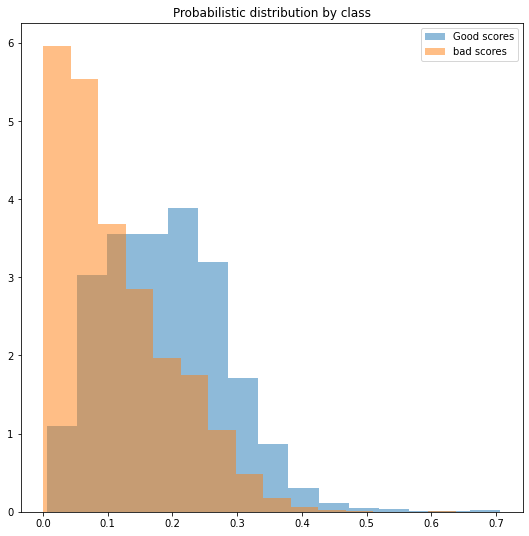

In [ ]:
plt.figure(figsize=(9, 9))

plt.title("Probabilistic distribution by class")

plt.hist(predictions[y_test==1], bins=15, label="Good scores", alpha=0.5,density=True)

plt.hist(predictions[y_test==0], bins=15, label="bad scores", alpha=0.5,density=True)
plt.legend()
plt.show()

In [ ]:
# getting precision, recall for each threshold of the output probability of the model 

precision, recall, thresholds = precision_recall_curve(y_test, predictions)

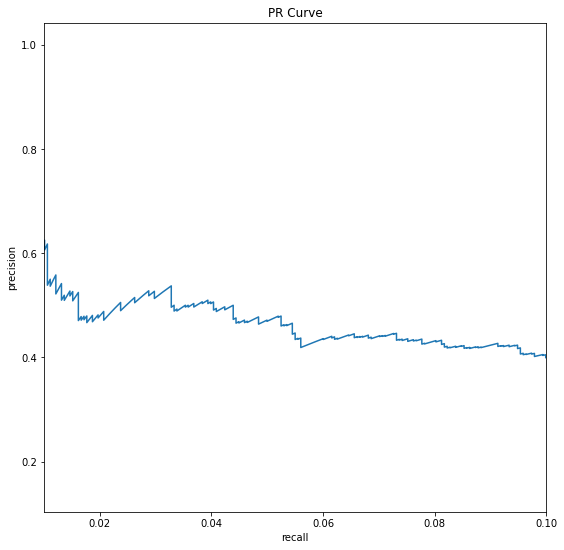

In [ ]:
plt.figure(figsize=(9, 9))
plt.title("PR Curve")

plt.plot(recall[::-1], precision[::-1])

plt.xlabel("recall")
plt.xlim((0.01, 0.1))
plt.ylabel("precision")

plt.show()

The recall should be between 1% and 10%

So we choose max precision while the recall in (0.01, 0.1)

In [ ]:
lim_recall_cond = (recall > 0.01) & (recall < 0.1)

In [ ]:
print("max precision (s.t. recall in (0.01, 0.1)) =", precision[lim_recall_cond].max())

max precision (s.t. recall in (0.01, 0.1)) = 0.625


In [ ]:
print("optimal recall =", recall[lim_recall_cond][precision[lim_recall_cond].argmax()])

optimal recall = 0.010090817356205853


In [ ]:
thresholds = np.concatenate([[0], thresholds])

prob_thrsh = thresholds[lim_recall_cond][precision[lim_recall_cond].argmax()]

print("optimal probability threshold =", prob_thrsh)

optimal probability threshold = 0.43813377618789673


We say that the score is good (i.e. we mark the label as 1) if predicted probability of the model is greater than optimal probability threshold

In [ ]:
print("the average of selected scores =", test_scores[predictions > prob_thrsh].mean())

the average of selected scores = 0.1475
